In [34]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [35]:
data = pd.read_csv('EVChargingStationUsage.csv')

C:\Users\balda\AppData\Local\Temp\ipykernel_3172\48901969.py:1: DtypeWarning: Columns (29,30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('EVChargingStationUsage.csv')


In [36]:
print('Pre dedup: ', len(data))

data = data.drop_duplicates()

print('Post dedup: ', len(data))

Pre dedup:  259415
Post dedup:  259411


There are 4 duplicates. Shouldn't change anything but might as well drop it.

In [37]:
data.columns

Index(['Station Name', 'MAC Address', 'Org Name', 'Start Date',
       'Start Time Zone', 'End Date', 'End Time Zone',
       'Transaction Date (Pacific Time)', 'Total Duration (hh:mm:ss)',
       'Charging Time (hh:mm:ss)', 'Energy (kWh)', 'GHG Savings (kg)',
       'Gasoline Savings (gallons)', 'Port Type', 'Port Number', 'Plug Type',
       'EVSE ID', 'Address 1', 'City', 'State/Province', 'Postal Code',
       'Country', 'Latitude', 'Longitude', 'Currency', 'Fee', 'Ended By',
       'Plug In Event Id', 'Driver Postal Code', 'User ID', 'County',
       'System S/N', 'Model Number'],
      dtype='object')

In [38]:
data['Start Date'].min(), data['Start Date'].max() 

('1/1/2012 13:24', '9/9/2020 9:56')

Roughly 9 years of data.

In [39]:
print('Number of stations: ', data['Station Name'].drop_duplicates().count())

Number of stations:  47


In [40]:
data['Station Name'].drop_duplicates()

0             PALO ALTO CA / HAMILTON #1
10            PALO ALTO CA / HAMILTON #2
155               PALO ALTO CA / HIGH #4
390             PALO ALTO CA / BRYANT #2
414             PALO ALTO CA / BRYANT #1
26085              PALO ALTO CA / MPL #4
26087              PALO ALTO CA / MPL #6
26088              PALO ALTO CA / MPL #2
26219              PALO ALTO CA / MPL #1
26243              PALO ALTO CA / MPL #5
26508              PALO ALTO CA / MPL #3
29733     PALO ALTO CA / RINCONADA LIB 2
29735     PALO ALTO CA / RINCONADA LIB 1
29756     PALO ALTO CA / RINCONADA LIB 3
40632          PALO ALTO CA / WEBSTER #1
40638             PALO ALTO CA / HIGH #1
40645          PALO ALTO CA / WEBSTER #2
53948     PALO ALTO CA / TED THOMPSON #1
53953        PALO ALTO CA / CAMBRIDGE #1
53956           PALO ALTO CA / BRYANT #3
53969          PALO ALTO CA / WEBSTER #3
53973        PALO ALTO CA / CAMBRIDGE #2
100452            PALO ALTO CA / HIGH #2
100486            PALO ALTO CA / HIGH #3
128088          

Some have very similar name. It seems that these are plugins after all.

In [41]:
data[['Station Name', 'Address 1']].drop_duplicates()

,Station Name,Address 1
0,PALO ALTO CA / HAMILTON #1,250 Hamilton Ave
10,PALO ALTO CA / HAMILTON #2,250 Hamilton Ave
155,PALO ALTO CA / HIGH #4,528 High St
390,PALO ALTO CA / BRYANT #2,Bryant St
414,PALO ALTO CA / BRYANT #1,Bryant St
...,...,...
259199,PALO ALTO CA / SHERMAN 2,350 Sherman Ave
259240,PALO ALTO CA / SHERMAN 5,350 Sherman Ave
259255,PALO ALTO CA / SHERMAN 15,350 Sherman Ave
259334,PALO ALTO CA / SHERMAN 11,350 Sherman Ave


Something's off. 47 stations but 63 combinations of station address.

In [42]:
station_address = data.groupby('Station Name')['Address 1'].nunique().reset_index(name='Unique addresses')
stations_with_double_address = list(station_address[station_address['Unique addresses'] > 1]['Station Name'])

filtered_data = data[data['Station Name'].isin(stations_with_double_address)].groupby(['Station Name', 'Address 1'])['Plug In Event Id'].nunique()
filtered_data

Station Name                    Address 1         
PALO ALTO CA / BRYANT #1        445 Bryant St         2408
                                Bryant St             9688
PALO ALTO CA / BRYANT #2        445 Bryant St         2640
                                Bryant St             9261
PALO ALTO CA / CAMBRIDGE #1     400 Cambridge Ave     6479
                                475 Cambridge Ave     4684
PALO ALTO CA / CAMBRIDGE #2     400 Cambridge Ave     6170
                                475 Cambridge Ave     3086
PALO ALTO CA / HIGH #2          528 High St           5737
                                528 high st           1192
PALO ALTO CA / HIGH #3          528 High St           8316
                                528 High St.             1
PALO ALTO CA / HIGH #4          528 High St           8634
                                528 High St.           871
PALO ALTO CA / RINCONADA LIB 1  1213 Newell Rd        4133
                                1520 Walnut Dr        2079
PALO 

Bunch of addresses look weird but checked on google maps and is the same or very close location. We can assume that this is fine and the numbers denote plugs while names denote stations.

In [43]:
data = data.rename(columns={'Station Name': 'Plug Name'})
data['Station Name'] = data['Plug Name'].str[15:-3]
data['Station Name'] = data['Station Name'].replace({
    'RINCONADA LI': 'RINCONADA LIB',
    'BRYANT ': 'BRYANT',
    'SHERMA': 'SHERMAN'
})

data['Station Name'].drop_duplicates()

0              HAMILTON
155                HIGH
390              BRYANT
26085               MPL
29733     RINCONADA LIB
40632           WEBSTER
53948      TED THOMPSON
53953         CAMBRIDGE
258738          SHERMAN
Name: Station Name, dtype: object

Renamed `Station Name` into `Plug Name` and created nice and pretty brand new `Station Name`.

In [44]:
empty_values_per_column = data.isna().sum().sort_values(ascending=False)
print(empty_values_per_column)

County                             84664
Model Number                       78947
System S/N                         78947
EVSE ID                            78947
Driver Postal Code                  8402
User ID                             7677
Currency                            1788
Ended By                             248
Transaction Date (Pacific Time)      209
Port Type                              9
Country                                0
Latitude                               0
Plug Name                              0
Longitude                              0
Fee                                    0
State/Province                         0
Plug In Event Id                       0
Postal Code                            0
Address 1                              0
City                                   0
MAC Address                            0
Plug Type                              0
Port Number                            0
Gasoline Savings (gallons)             0
GHG Savings (kg)

We have null values but this is only the case with features that seem useless form the modelling perspective so we don't need to deal with it.

In [45]:
data['Date'] = pd.to_datetime(data['Start Date']).dt.date
data['Start Day'] = pd.to_datetime(data['Start Date']).dt.day
data['Start Month'] = pd.to_datetime(data['Start Date']).dt.month
data['Start Year'] = pd.to_datetime(data['Start Date']).dt.year

Created `Day` (`Start Date` without hour), `Start Day`, `Start Month` and `Start Year` which we can use for aggregates later.

In [46]:
date1 = datetime(2011, 7, 29)
date2 = datetime(2020, 12, 31)

difference = date2 - date1
difference

datetime.timedelta(days=3443)

In [49]:
data['Date'].drop_duplicates()

0         2011-07-29
1         2011-07-30
6         2011-07-31
9         2011-08-01
10        2011-08-02
             ...    
259272    2020-12-27
259298    2020-12-28
259327    2020-12-29
259362    2020-12-30
259389    2020-12-31
Name: Date, Length: 3444, dtype: object

Length matches so we have all the days.

In [50]:
data.to_csv('palo_alto_old_cleaned.csv')

### Rest of it is just exploration.

In [57]:
daily_agg = data.groupby('Start Day')['Energy (kWh)'].sum('Energy (kWh)')
monthly_agg = data.groupby('Start Month')['Energy (kWh)'].sum('Energy (kWh)')
yearly_agg = data.groupby('Start Year')['Energy (kWh)'].sum('Energy (kWh)')

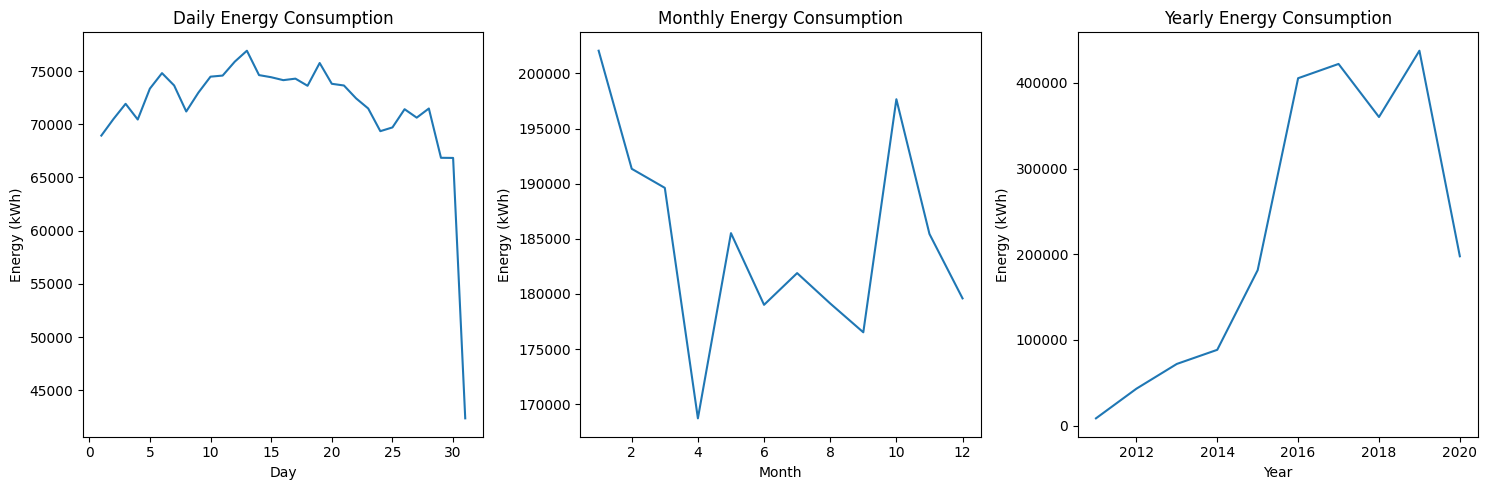

In [58]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

daily_agg.plot(ax=axes[0], title='Daily Energy Consumption', xlabel='Day', ylabel='Energy (kWh)')
monthly_agg.plot(ax=axes[1], title='Monthly Energy Consumption', xlabel='Month', ylabel='Energy (kWh)')
yearly_agg.plot(ax=axes[2], title='Yearly Energy Consumption', xlabel='Year', ylabel='Energy (kWh)')

plt.tight_layout()
plt.show()

In [70]:
date_agg = data.groupby('Date')['Energy (kWh)'].sum('Energy (kWh)')
month_year_agg = data.groupby(['Start Month', 'Start Year'])['Energy (kWh)'].sum('Energy (kWh)')

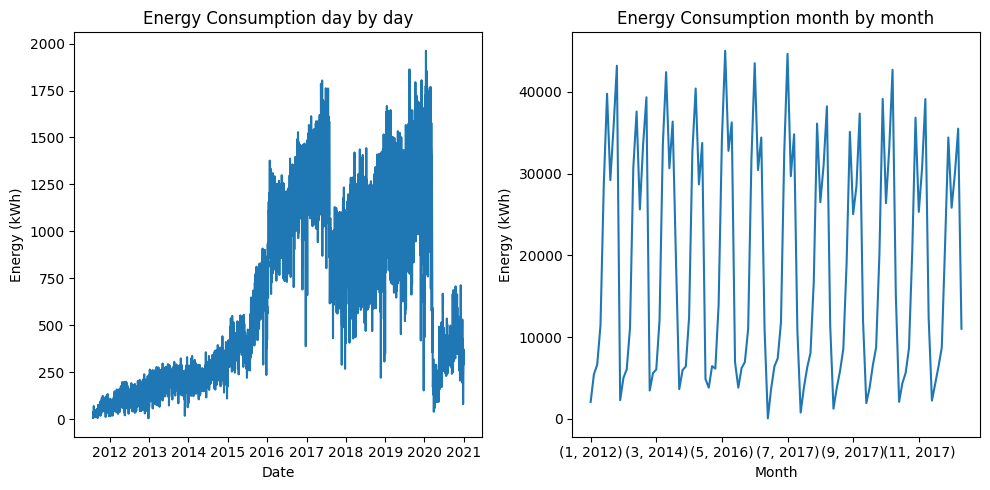

In [71]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

date_agg.plot(ax=axes[0], title='Energy Consumption day by day', xlabel='Date', ylabel='Energy (kWh)')
month_year_agg.plot(ax=axes[1], title='Energy Consumption month by month', xlabel='Month', ylabel='Energy (kWh)')

plt.tight_layout()
plt.show()

In [73]:
month_year_agg = pd.DataFrame(month_year_agg).reset_index()

In [78]:
month_year_agg.sort_values(['Start Year','Energy (kWh)'])

,Start Month,Start Year,Energy (kWh)
54,7,2011,72.437273
64,8,2011,781.309083
74,9,2011,1251.386747
84,10,2011,1934.620528
94,11,2011,2084.733485
...,...,...,...
103,11,2020,12398.792000
93,10,2020,15185.087000
26,3,2020,19470.564000
17,2,2020,39321.822000


In [80]:
# Define a function to select top 2 records
def top_n_records(group):
    return group.nsmallest(2, 'Energy (kWh)')

# Apply the function to each group within each year
top_2_records = month_year_agg.groupby('Start Year', group_keys=False).apply(top_n_records)

# Sort the result by 'Start Year' and 'Start Month'
top_2_records_sorted = top_2_records.sort_values(['Start Year', 'Start Month', 'Energy (kWh)'], ascending=[True, True, False])

# Print the sorted top 2 records for each year with month displayed
print(top_2_records_sorted)


     Start Month  Start Year  Energy (kWh)
54             7        2011     72.437273
64             8        2011    781.309083
0              1        2012   2068.824892
9              2        2012   2296.407581
1              1        2013   5462.499676
10             2        2013   5034.552628
11             2        2014   6069.545377
20             3        2014   6041.383825
12             2        2015  11137.775658
48             6        2015  11010.997615
4              1        2016  28586.852509
13             2        2016  30707.639780
80             9        2017  25031.371000
100           11        2017  25310.641000
15             2        2018  25615.094000
81             9        2018  28453.234000
16             2        2019  33591.070000
34             4        2019  33733.581000
35             4        2020   4860.954000
44             5        2020   6942.764000
